### Implementation of a trinomial tree model for European/American vanilla option

*The algorithm*

Recall the notation that:
\begin{align*}
s^n_{(j,k)}=S_0 u^{n-j-k} m^j d^k,\qquad n=0,1,...,N\quad j,k=0,1,...,n\quad j+k \leqslant n
\end{align*}
is the $(j,k)^{th}$ possible stock price level at time $n$, and $V^n_{(j,k)}$ is the time-$n$ option value when the stock price is $s^n_{(j,k)}$. 

Then the pricing procedure is:

1. Compute the option price at the terminal time $N$ which is simply the option payoff function, i.e. $V^N=g(S_N)$:
$$V^N_{(j,k)}=g(S_0 u^{n-j-k} m^j d^k) \quad \text{for each }k=0,1,...,N$$


2. Loop backward in time: for $n=N-1,N-2,...,0$, compute

Euro. option: 
$$V^{n}_{(j,k)} = e^{-r\triangle t}[q_u V^{n+1}_{(j,k)} + q_m V^{n+1}_{(j+1,k)} + q_d V^{n+1}_{(j,k+1)}]\quad\text{for each }j,k=0,1,...,n \quad j+k \leqslant n$$

Amer. option: 
$$V^{n}_{(j,k)} = \max(g(s^n_{(j,k)}),e^{-r\triangle t}[q_u V^{n+1}_{(j,k)} + q_m V^{n+1}_{(j+1,k)} + q_d V^{n+1}_{(j,k+1)}])\quad\text{for each }j,k=0,1,...,n \quad j+k \leqslant n$$

  
3. The required time-zero option value is $V^0_{(0,0)}$

$ud = m = 1$ provides recombining property. Then we have:

$$s^n_{(j,k)}=S_0 u^{n-j-k} m^j d^k =  S_0 u^{n-j-k} d^k$$

Load the usual packages

In [1]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import pandas as pd

Implementation of the above pricing algorithm:

In [2]:
def TrinomailTree(s0, u, d, qu, qm, qd, R, N, payoff, american=False):
    # Kamrad-Ritchken parametrisation #
        
    # Create empty arrays to store the stock price and option value at each node
    V = np.zeros(((N+1)*2 - 1, N+1))
    V[:] = np.nan
    S = np.zeros(((N+1)*2 - 1, N+1))
    S[:] = np.nan
    
    # Set up S[j,k,n] = s0 * u^(n-j-k) * d^k 
    for t in range(N+1):
      a = [0] * t
      b = [i for i in range(t, -1, -1)]
      c = [i for i in range(0,t+1)]
      S[0:(t+1)*2 -1, t] = s0 * u**np.array(b+a) * d**np.array(a+c)
    
    # Compute the option price at terminal time
    V[:,N] = payoff(S[:,N])
    
    # Loop backward in time
    for t in reversed(range(N)):
        if american == True:
          V[0:(t+1)*2 -1, t] = np.maximum(payoff(S[0:(t+1)*2 -1, t]), (qu * V[0:(t+1)*2 -1,t+1] + qm * V[1:(t+1)*2, t+1] + qd * V[2:(t+1)*2 +1, t+1]) / R)  # The R is going to be taken as R=exp(r dt), which represents the interest rate factor
        else:
          V[0:(t+1)*2 -1, t] = (qu * V[0:(t+1)*2 -1,t+1] + qm * V[1:(t+1)*2, t+1] + qd * V[2:(t+1)*2 +1, t+1]) / R   
        
    return V, S     # get the function to return the whole tree of stock prices and option values

*Choosing the tree parameters*

There are a number of ways we can choose the tree parameters. We consider here the Kamrad-Ritchken parametrisation where:

$$u = e^{\lambda \sigma \sqrt{2\Delta t}}, \quad m = 1, \quad d = e^{-\lambda \sigma \sqrt{2\Delta t}}$$
$$q_{u} = \frac{1}{2\lambda^2} + \frac{(r - \frac{\sigma^2}{2})\sqrt{\Delta t}}{2\lambda \sigma}, \quad q_m = 1 - \frac{1}{\lambda^2},\quad q_d =\frac{1}{2\lambda^2} - \frac{(r - \frac{\sigma^2}{2})\sqrt{\Delta t}}{2\lambda \sigma}.$$

In [3]:
def GetTrinomialCRRPara(r, lam,  dt, sigma):
  u = np.exp(lam * sigma * np.sqrt(dt))
  d= 1/u
  R = np.exp(r * dt)
  qu = 1/(2* lam**2) + (r - sigma**2 /2) * np.sqrt(dt) / (2 * lam * sigma)
  qm = 1 - 1/(lam ** 2)
  qd = 1/(2* lam**2) - (r - sigma**2 /2) * np.sqrt(dt) / (2 * lam * sigma)
  return u, d, qu, qm, qd, R

In [4]:
GetTrinomialCRRPara(r = 0.01, lam = 1.25, dt = 1/3, sigma=0.2)

(1.155274025440143,
 0.8655955020013665,
 0.3084529946162075,
 0.36,
 0.3315470053837925,
 1.0033388950668758)

Now we try to use a 2-period tree to price a European call option which payoff function is $(S_T - K)^{+}$. Parameters are: initial stock price $S_0=100$, strike price $K=100$, maturity $T=1$ year, interest rate $r=1\%$ and volatility $\sigma=20\%$.

### Black Scholes for European Call Option: 

$ C(S, t) = S N(d+) - K e^{-r(T-t)} N(d-)$

$ d\pm = \frac{log(S/K) + (r \pm \frac{\sigma ^ 2}{2}(T-t))}{\sigma \sqrt{t}} $

In [5]:
from scipy.stats import norm

def d1(S,K,T,r,sigma):
    return(np.log(S/K) + (r + sigma**2/2.)*T)/(sigma * np.sqrt(T))

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma) - sigma * np.sqrt(T)


def bs_call(S,K,T,r,sigma):
    return S * norm.cdf(d1(S,K,T,r,sigma)) - K * np.exp(-r*T) * norm.cdf(d2(S,K,T,r,sigma))

In [6]:
def price_plot(s0, r, T, sigma, K):
    CallPayoff = lambda x : np.maximum(x - K, 0)    

    Lam = [1, 1.25, 1.5, 1.75]
    prices = np.zeros((100, 4))

    for lam in Lam:
        for N in range(2, 102):
            u, d, qu, qm, qd, R = GetTrinomialCRRPara(r, lam, T/N, sigma)
            V, S = TrinomailTree(s0, u, d, qu, qm, qd, R, N, CallPayoff)
            prices[N-2][Lam.index(lam)] = V[0,0]
    
    df = pd.DataFrame(prices, columns=['lambda = 1', 'lambda = 1.25', 'lambda = 1.5', 'lambda = 1.75'])
    bs = bs_call(s0, K, T, r, sigma)

    plt.figure(figsize = (20,15))
    for i in df.columns:
        plt.plot(df[i], label = str(i))
    plt.axhline(y=bs, color='k', linestyle='-', label = 'BS = ' + str(round(bs,3)))
    plt.legend(loc="upper right")
    plt.xlabel("N", fontsize=15)
    plt.ylabel("Price at initial time", fontsize=15)
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


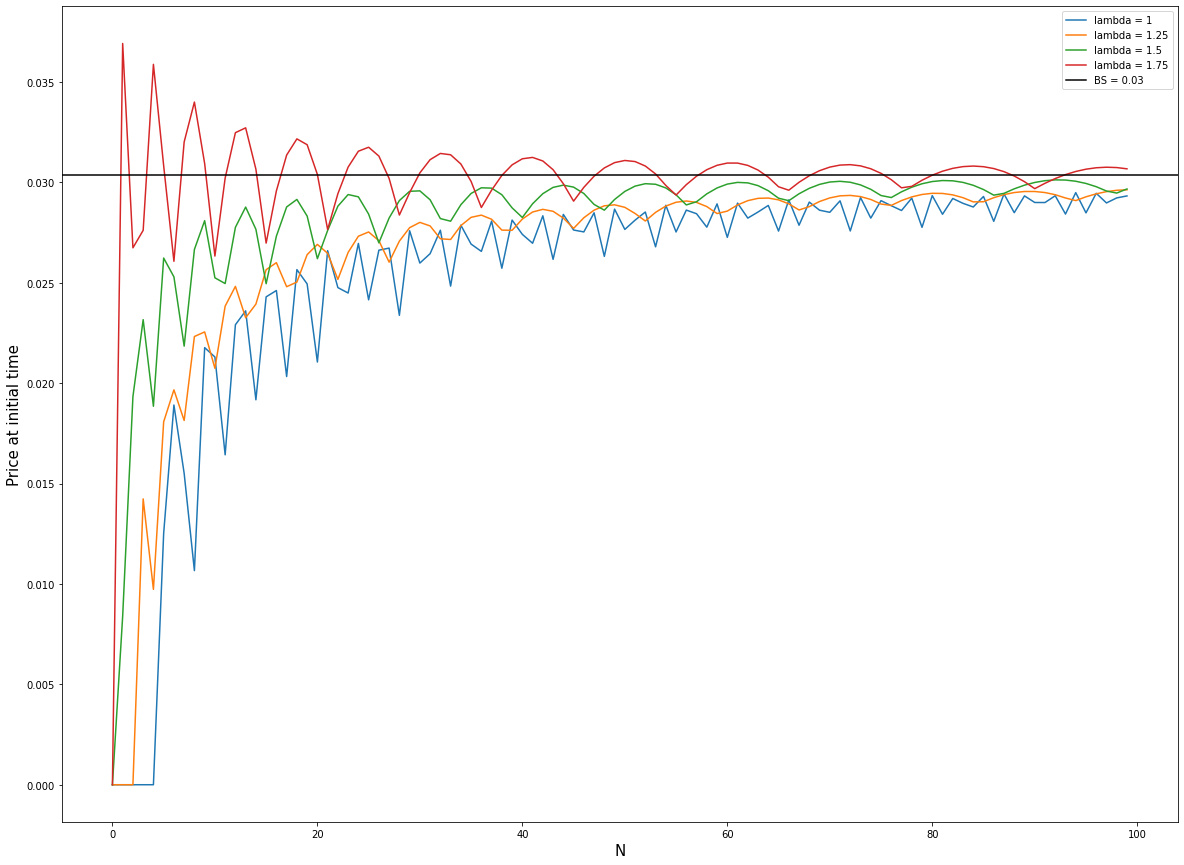

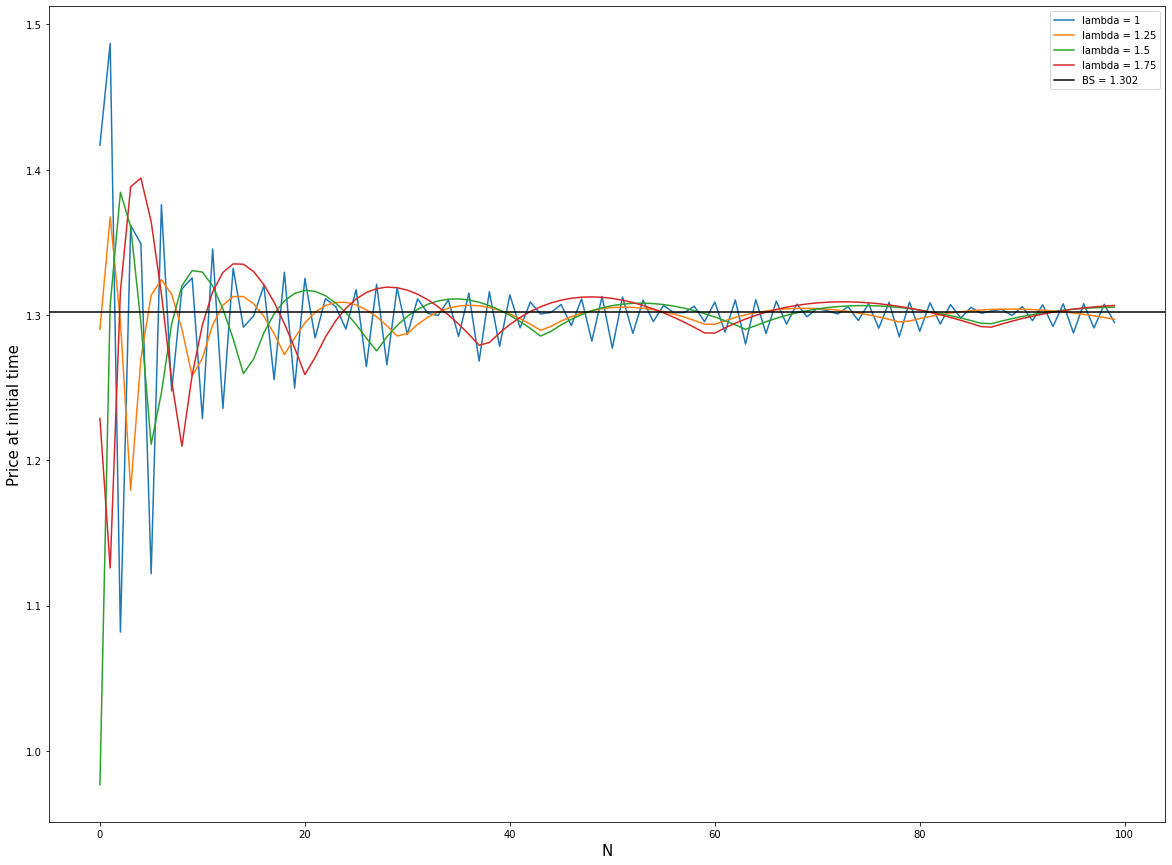

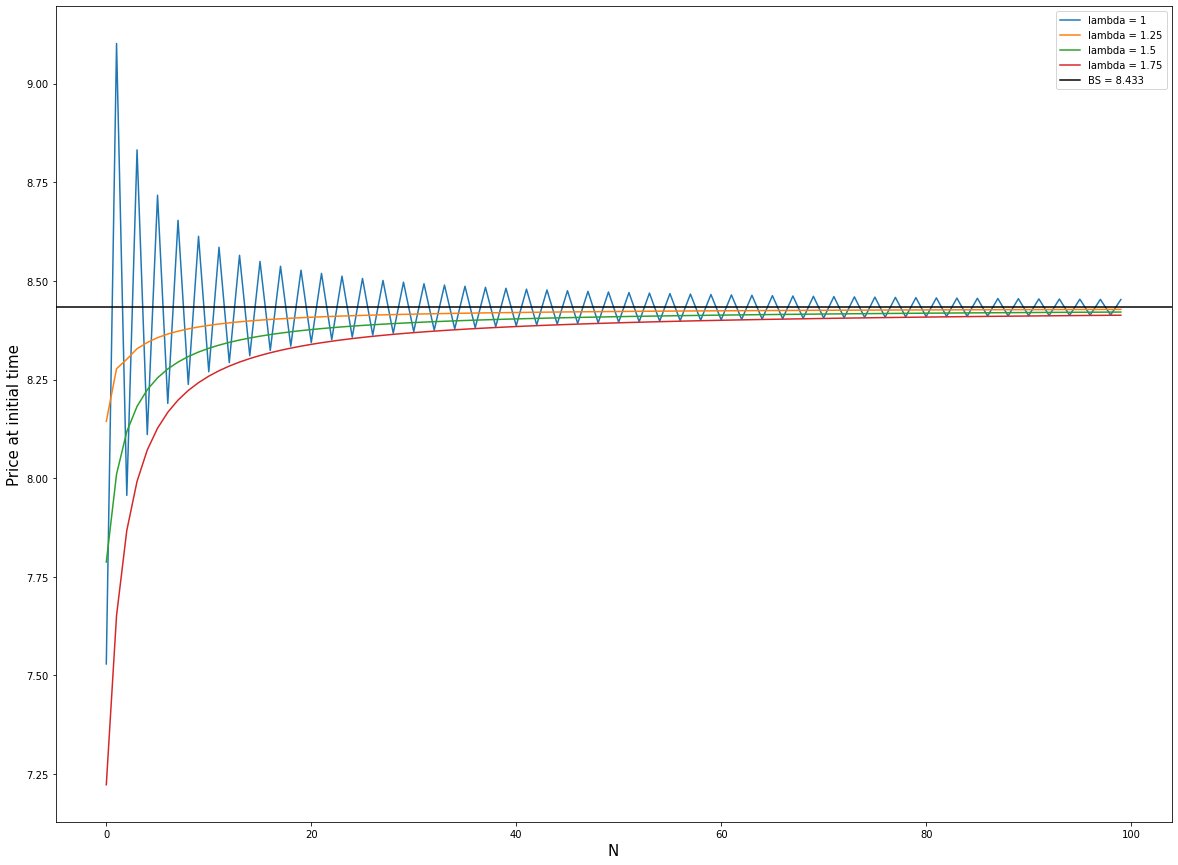

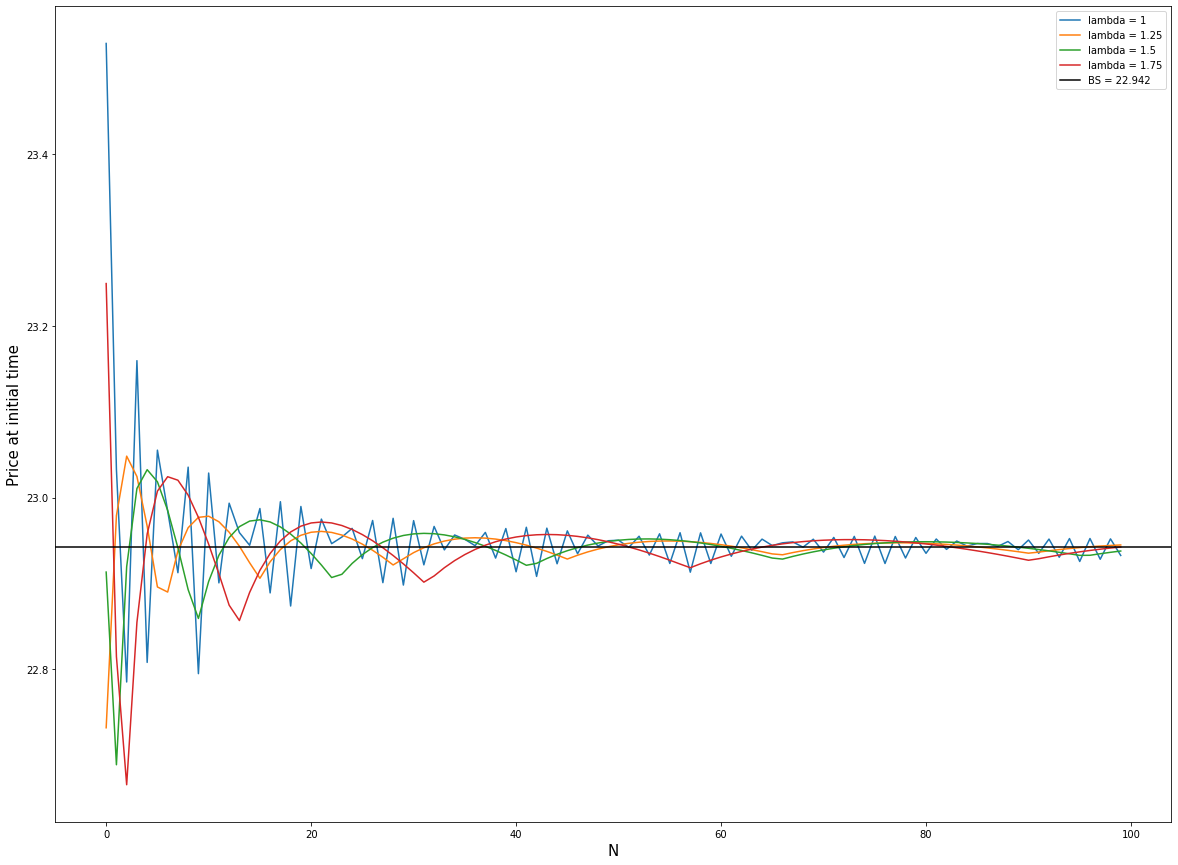

In [7]:
r, T, sigma, K = 0.01, 1, 0.2, 100

price_plot(60, r, T, sigma, K)
plt.savefig('price60.eps',format = 'eps')

price_plot(80, r, T, sigma, K)
plt.savefig('price80.eps',format = 'eps')

price_plot(100, r, T, sigma, K)
plt.savefig('price100.eps',format = 'eps')

price_plot(120, r, T, sigma, K)
plt.savefig('price120.eps',format = 'eps')
    

### Eurpean Option (c)
Different $S_0$ and $\lambda$

In [8]:
r, T, sigma, K = 0.01, 1, 0.2, 100     
N = 500
CallPayoff = lambda x : np.maximum(x - K, 0)    

# Exact Black Scholes
BS = []
for i in range(70, 131, 5):  # take 12 values in [70, 130]
    BS.append(bs_call(i, 100, 1, 0.01, 0.2))

# Using Trinomial Tree
table = []
Lam = [1, 1.25, 1.5, 1.75]

for j in range(70, 131, 5):
    for lam in Lam:
        u, d, qu, qm, qd, R = GetTrinomialCRRPara(r, lam, T/N, sigma)
        V, S = TrinomailTree(j, u, d, qu, qm, qd, R, N, CallPayoff)
        table.append(V[0,0])


In [9]:
table = np.array(table).reshape(13,4)
table = pd.DataFrame(table, columns=['lambda = 1', 'lambda = 1.25', 'lambda = 1.5', 'lambda = 1.75'])
table['BS'] = BS
table = table.round(4)
table['Initial'] = [x for x in range(70, 131, 5)]
table

,lambda = 1,lambda = 1.25,lambda = 1.5,lambda = 1.75,BS,Initial
0,0.2783,0.2789,0.2796,0.2796,0.2795,70
1,0.6444,0.6457,0.6462,0.6465,0.6460,75
2,1.3033,1.3013,1.3028,1.3025,1.3022,80
3,2.3460,2.3486,2.3470,2.3489,2.3478,85
4,3.8603,3.8627,3.8611,3.8620,3.8614,90
5,5.8874,5.8895,5.8879,5.8885,5.8878,95
6,8.4293,8.4322,8.4308,8.4292,8.4333,100
7,11.4720,11.4715,11.4714,11.4682,11.4698,105
8,14.9472,14.9463,14.9438,14.9427,14.9447,110
9,18.7922,18.7931,18.7932,18.7899,18.7919,115


In [10]:
table.to_csv('table.csv', index = False, header=False)

In [11]:
# compute absolute difference 
for column in table.columns[:4]:
    print(sum(abs(table['BS'] - table[column])))
# so we should probably choose lambda = 1.5

0.018200000000002603
0.012800000000002032
0.010599999999997722
0.014499999999996183


### American Option
Amer. option: 
$$V^{n}_{(j,k)} = \max(g(s^n_{(j,k)}),e^{-r\triangle t}[q_u V^{n+1}_{(j,k)} + q_m V^{n+1}_{(j+1,k)} + q_d V^{n+1}_{(j,k+1)}])\quad\text{for each }j,k=0,1,...,n \quad j+k \leqslant n$$

Now let's try to price an American version of the put instead.

In [12]:
# 2.(b)
r, T, sigma, K = 0.01, 1, 0.2, 100
lam = 1.5     
N = 500                                         
CallPayoff = lambda x : np.maximum(x - K, 0)   

American = []
u, d, qu, qm, qd, R = GetTrinomialCRRPara(r, lam, T/N, sigma)
Intrinsic = CallPayoff(np.arange(70, 130))
for i in range(70, 130):
    V, S = TrinomailTree(i, u, d, qu, qm, qd, R, N, CallPayoff, True)
    American.append(V[0,0])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


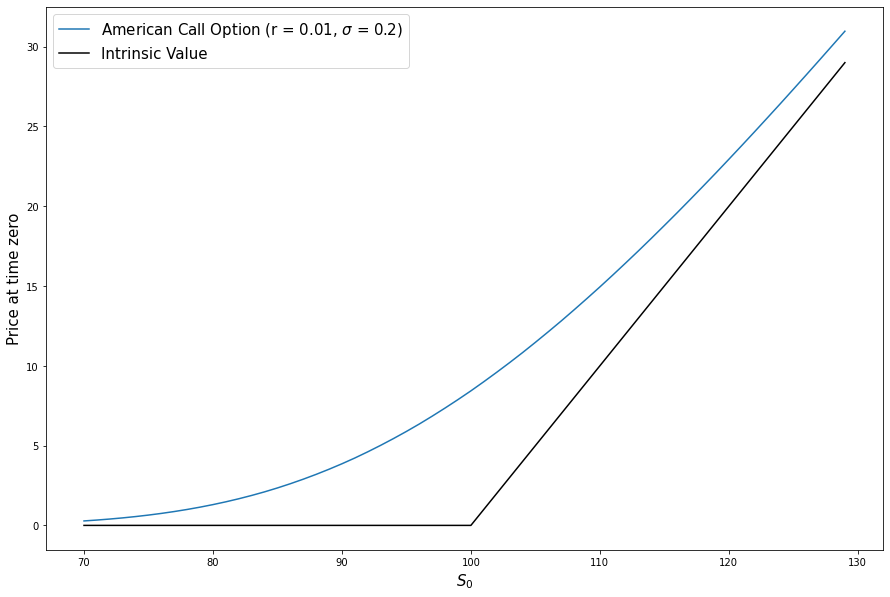

In [13]:
plt.figure(figsize = (15,10))
plt.plot(np.arange(70, 130), American, label = r'American Call Option (r = 0.01, $\sigma$ = 0.2)')
plt.plot(np.arange(70, 130), Intrinsic, color = 'black',label = 'Intrinsic Value')
plt.xlabel(r'$S_0$', fontsize=15)
plt.ylabel("Price at time zero", fontsize=15)
plt.legend(loc='upper left', fontsize = 15)
plt.savefig('american_call.eps',format = 'eps')

In [14]:
# 2.(c)

PutPayoff = lambda x: np.maximum(K - x, 0)
T, K, lam = 1, 100, 1.5
N = 500   

Intrinsic_put = PutPayoff(np.arange(70, 130))
American_put = []
par = [(0.01, 0.2), (0.05, 0.2), (0.01, 0.45),(0.05, 0.45)]

for (i, j) in par:
    u, d, qu, qm, qd, R = GetTrinomialCRRPara(i, lam, T/N, j)
    for i in range(70, 130):
        V, S = TrinomailTree(i, u, d, qu, qm, qd, R, N, PutPayoff, True)
        American_put.append(V[0,0])


In [15]:
list(set(American_put[60:120]).intersection(Intrinsic_put))
# min = 19, i.e. S0 = 100 - 19 = 81

[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


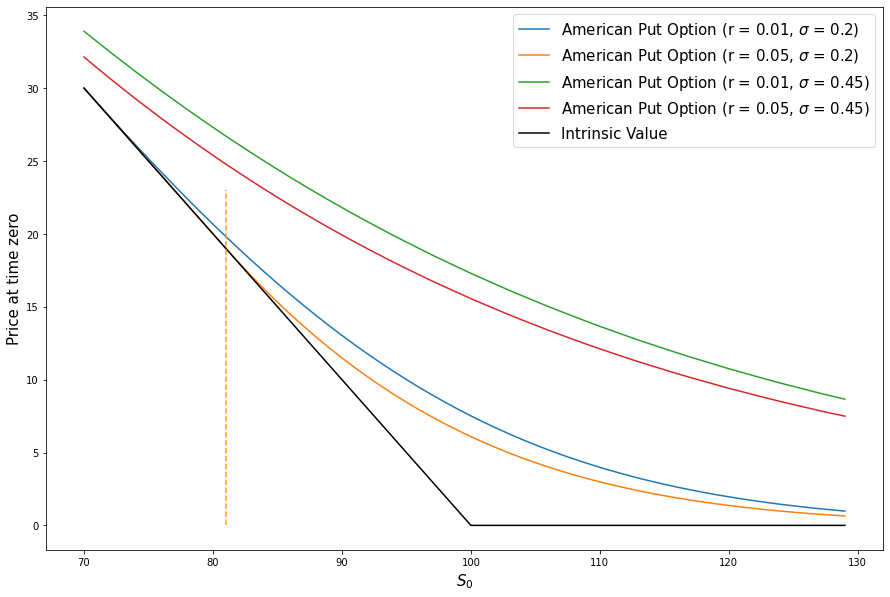

In [16]:
plt.figure(figsize = (15,10))
plt.plot(np.arange(70, 130), American_put[:60], label = r'American Put Option (r = 0.01, $\sigma$ = 0.2)')
plt.plot(np.arange(70, 130), American_put[60:120], label = r'American Put Option (r = 0.05, $\sigma$ = 0.2)')
plt.plot(np.arange(70, 130), American_put[120:180], label = r'American Put Option (r = 0.01, $\sigma$ = 0.45)')
plt.plot(np.arange(70, 130), American_put[180:240], label = r'American Put Option (r = 0.05, $\sigma$ = 0.45)')
plt.plot(np.arange(70, 130), Intrinsic_put, color = 'black', label = 'Intrinsic Value')
plt.plot((81,81), (0, 23), color = 'orange', linestyle='--')
plt.xlabel(r'$S_0$', fontsize=15)
plt.ylabel("Price at time zero", fontsize=15)
plt.legend(loc='upper right', fontsize = 15)
plt.savefig('american_put.eps',format = 'eps')


### Floatint strike lookback put option
Forward shooting grid method

In [17]:
V, S = TrinomailTree(100, 2, 1/2, 0.4, 0.3, 0.4, 1, 2, PutPayoff, american=False)

In [18]:
def gridM(s0, u, N):

    M = np.zeros((N+1, N+1))

    for t in range(N+1):
        M[0:t+1, t] = s0* u**np.arange(t, -1, -1)
    return M

In [19]:
def floatingstrike(N, qu, qm, qd, R, s0, u, d, american =False):
    V = dict()

    #compute trinomial tree price S
    S = np.zeros(((N+1)*2 - 1, N+1))
    S[:] = np.nan
    for t in range(N+1):
        a = [0] * t
        b = [i for i in range(t, -1, -1)]
        c = [i for i in range(0,t+1)]
        S[0:(t+1)*2 -1, t] = s0 * u**np.array(b+a) * d**np.array(a+c)
    ######################
    M = gridM(s0, u, N) 
    M_value = M[0:N+1, N]
    S_value = S[0: 2*N + 1, N]

    a = [0] * N
    b = [i for i in range(t, -1, -1)]
    c = [i for i in range(0,t+1)]
    k_list = a+c
    j_list = [N-(b+a)[i] - k_list[i] for i in range(2*N+1)]
    list_jk = [(j_list[i], k_list[i]) for i in range(2*N + 1)]


    #terminal case
    V[N] = np.zeros((N+1, 2*N + 1))
    for l in range(N+1):
        for (j,k) in list_jk:
            if l <= j+2*k:
                V[N][l, (j+2*k)] = M_value[l] - S_value[j+2*k]  
    #####################

    Shooting = lambda j,k,l: min(j + 2*k, l+1) #shooting function 

    for t in reversed(range(N)):
        V[t] = np.zeros((t+1, 2*t + 1))
        a = [0] * t
        b = [x for x in range(t, -1, -1)]
        c = [x for x in range(0, t+1)]

        M = gridM(s0, u, t) 
        M_value = M[0:t+1, t]
        S_value = S[0: 2*t + 1, t]

        k_list = a+c
        j_list = [t-(b+a)[x] - k_list[x] for x in range(2*t+1)]
        list_jk = [(j_list[x], k_list[x]) for x in range(2*t + 1)] #construct (j,k) coordinate

        for l in range(t+1):
            for (j,k) in list_jk:
                if l <= j+2*k:
                    if american == True:
                        V[t][l, (j+2*k)] = max(M_value[l] - S_value[j+2*k], (qu * V[t+1][Shooting(j,k,l), (j+2*k)] + qm * V[t+1][Shooting(j+1,k,l), j+1+2*k] + qd * V[t+1][Shooting(j,k+1,l),j+2*(k+1)]) / R)
                    else:
                        V[t][l, (j+2*k)] = (qu * V[t+1][Shooting(j,k,l), (j+2*k)] + qm * V[t+1][Shooting(j+1,k,l), j+1+2*k] + qd * V[t+1][Shooting(j,k+1,l),j+2*(k+1)]) / R

    return V[0][0,0]

In [20]:
# example
lam = 1.25
sigma = 0.2
T = 1
N = 2
u, d, qu, qm, qd, R = GetTrinomialCRRPara(r, lam, T/N, sigma)
V_Euro = floatingstrike(2, qu, qm, qd, R, 100, u, d, False)
V_Ameri = floatingstrike(2, qu, qm, qd, R, 100, u, d, True)
V_Euro, V_Ameri

(9.10797406033635, 9.273449482855904)

In [21]:
# 3.(b)
import timeit
Euro = []
Ameri = []
time_euro = []
time_ameri=[]

lam = 1.5
sigma = 0.2
T = 1
s0 = 100 

List = [2, 10, 50, 100, 500]

for N in List:
    u, d, qu, qm, qd, R = GetTrinomialCRRPara(r, lam, T/N, sigma)
    start = timeit.default_timer()
    Euro.append(floatingstrike(N, qu, qm, qd, R, s0, u, d, False))
    stop = timeit.default_timer()
    time_euro.append(stop-start)

    start = timeit.default_timer()
    Ameri.append(floatingstrike(N, qu, qm, qd, R, s0, u, d, True))
    stop = timeit.default_timer()
    time_ameri.append(stop-start)



In [22]:
Euro, Ameri

([7.9469699397931715,
  11.73646898132436,
  14.114690752174875,
  14.750882573242949,
  15.6456755422277],
 [8.062864320442088,
  11.868506980380323,
  14.246450610800135,
  14.883067718731466,
  15.77848531192888])

In [23]:
time_euro, time_ameri

([0.0007701459999225335,
  0.0076490080000439775,
  0.3202843650005889,
  2.2817141509995054,
  307.72533768500034],
 [0.0010746429998107487,
  0.00588047600012942,
  0.39932331900035933,
  2.611102273999677,
  415.5094697099994])

In [24]:
floatingstrike = pd.DataFrame(list(zip(List, Euro, time_euro, Ameri, time_ameri)), columns=['N','European','Time for European', 'American', 'Time for American'])
floatingstrike

,N,European,Time for European,American,Time for American
0,2,7.946970,0.000770,8.062864,0.001075
1,10,11.736469,0.007649,11.868507,0.005880
2,50,14.114691,0.320284,14.246451,0.399323
3,100,14.750883,2.281714,14.883068,2.611102
4,500,15.645676,307.725338,15.778485,415.509470


In [25]:
floatingstrike.to_csv('floatingstrike.csv', index = False, header=False)